In [14]:
import numpy as np
import matplotlib.pyplot as plt

$$\mathrm{d} \textbf{Y}_t = - \mathrm{diag} (\textbf{x}) (\textbf{Y}_t - \textbf{y}_0) \, \mathrm{d}t + b (\textbf{w}^{\top} \textbf{Y}_t) \mathbb{1} \, \mathrm{d}t + \sigma (\textbf{w}^{\top} \textbf{Y}_t) \mathbb{1} \, \mathrm{d} W_t$$


In [15]:
def simulate_batch(Y0, y0, b_func, sigma_func, x, w, N, n, T, num_simulations):
    dt = T / n
    Y = np.zeros((n, num_simulations, N))
    Y[0] = Y0 
    ones = np.ones((num_simulations, N))

    for i in range(1, n):
        Y_prev = Y[i - 1]

        # w^T * Y : shape (num_simulations,)
        w_dot_Y = np.dot(Y_prev, w)

        # Drift
        drift = - (Y_prev - y0) * x  # shape (num_simulations, N)

        # Global drift
        global_drift = b_func(w_dot_Y).reshape(-1, 1) * ones  # shape (num_simulations, N)

        # Noise
        sigma_vals = sigma_func(w_dot_Y).reshape(-1, 1)
        noise = sigma_vals * np.sqrt(dt) * np.random.randn(num_simulations, 1) * ones

        # Update
        Y[i] = Y_prev + dt * drift + dt * global_drift + noise

    return Y  # shape: (n, num_simulations, N)


### Modèle multifacteur à racine carrée

$$\mathrm{d} \textbf{V}_t^N = - \mathrm{diag} (\textbf{x})(\textbf{V}_t^N - v_0) \, \mathrm{d}t + (\theta - \lambda \textbf{w}^{\top}\textbf{V}_t^N) \mathbb{1} \, \mathrm{d}t + \nu \sqrt{\textbf{w}^{\top} \textbf{V}_t^N} \, \mathbb{1} \, \mathrm{d}W_t$$

$$b(x) = \theta - \lambda x, \quad \sigma(x) = \nu \sqrt{x}$$

#### Cas $N=2$

In [16]:
N = 2
x = np.array([1, 10])
w = np.array([1, 2])
lam = 0.3
nu = 0.3
V0 = 0.02
theta = 0.02
T = 100
v0 = V0 / (2 * (w[0]/x[0] + w[1]/x[1])) * (1/x)
n = 10**5
V_0 = v0

In [17]:
def b(x):
    return theta - lam * x

def sigma(x):
    return nu * np.sqrt(np.maximum(x, 0))

In [18]:
# === Simulation ===
trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, 1)

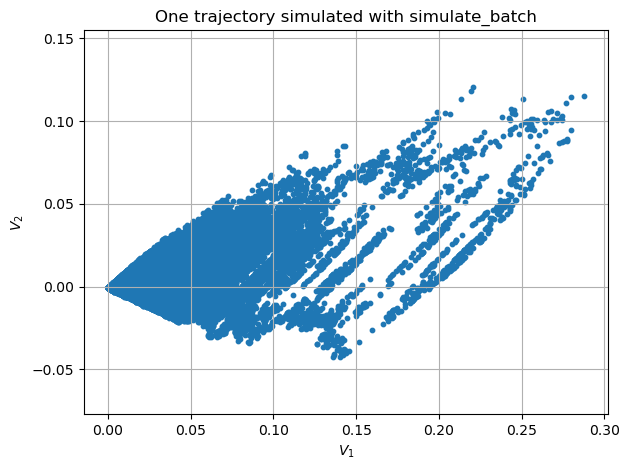

In [19]:
# Extraire la trajectoire 0 (la seule ici)
V = trajectories[:, 0, :]  # shape: (n, 2)

# Tracé des points uniquement (pas de lignes)
plt.scatter(V[:, 0], V[:, 1], s=10)

plt.xlabel(r"$V_1$")
plt.ylabel(r"$V_2$")
plt.title("One trajectory simulated with simulate_batch")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


#### Domaine
$$Q = \begin{pmatrix}
q & -q \\
w_1 & w_2
\end{pmatrix}$$
$$\mathcal{D} = \left\{ \textbf{y} \in \mathbb{R}_+^2 \ \middle| \ \textbf{w}^{\top} \textbf{y} \geq 0, \ y_1 \geq y_2 \right\}$$

In [20]:
Q = np.array([[1, -1],
              [w[0], w[1]]])

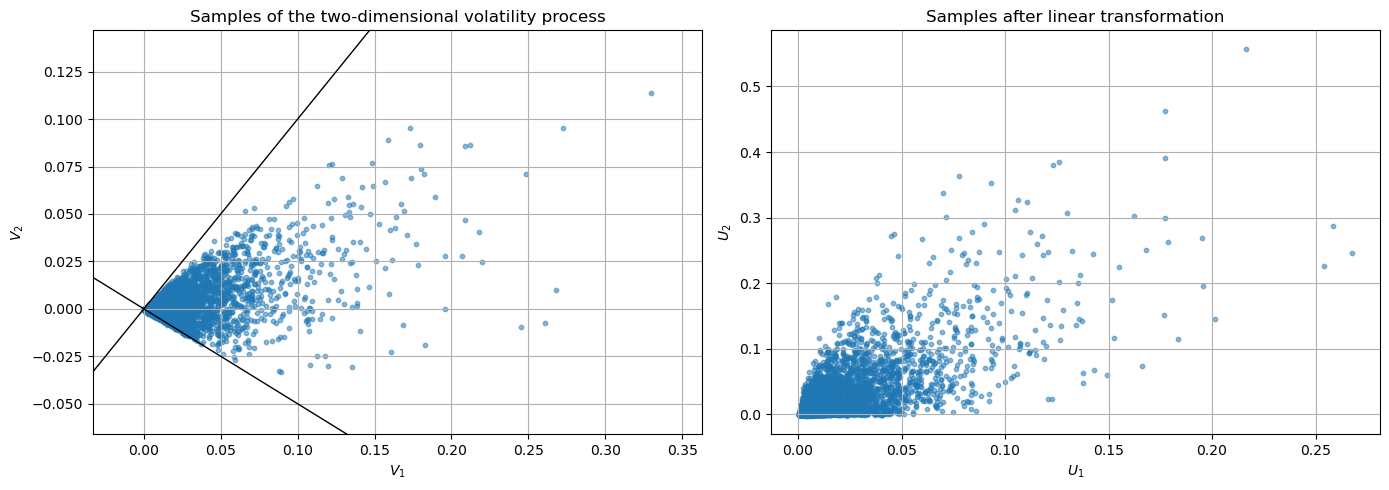

In [23]:
num_simulations = 5000

# === Simulation ===
trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, num_simulations)

# Extraire les points finaux (dernier pas de temps)
results = trajectories[-1]  # shape: (num_simulations, 2)
transformed = results @ Q.T  # shape: (num_simulations, 2)

# === Tracé des nuages de points ===
x_min, x_max = results[:, 0].min(), results[:, 0].max()
y_min, y_max = results[:, 1].min(), results[:, 1].max()
margin = 0.1 * max(x_max - x_min, y_max - y_min)
x_plot_min = x_min - margin
x_plot_max = x_max + margin
y_plot_min = y_min - margin
y_plot_max = y_max + margin

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# === Graphe gauche : espace original
axes[0].scatter(results[:, 0], results[:, 1], s=10, alpha=0.5)

x_vals = np.linspace(x_plot_min, x_plot_max, 300)
axes[0].plot(x_vals, x_vals, 'k-', linewidth=1)  # y1 = y2
slope = -(w[0] / w[1])
y_vals = slope * x_vals
axes[0].plot(x_vals, y_vals, 'k-', linewidth=1)  # w^T y = 0

axes[0].set_xlim(x_plot_min, x_plot_max)
axes[0].set_ylim(y_plot_min, y_plot_max)
axes[0].set_xlabel(r"$V_1$")
axes[0].set_ylabel(r"$V_2$")
axes[0].set_title("Samples of the two-dimensional volatility process")
axes[0].grid(True)

# === Graphe droite : espace transformé
axes[1].scatter(transformed[:, 0], transformed[:, 1], s=10, alpha=0.5)
axes[1].set_xlabel(r"$U_1$")
axes[1].set_ylabel(r"$U_2$")
axes[1].set_title("Samples after linear transformation")
axes[1].grid(True)

plt.tight_layout()
plt.show()



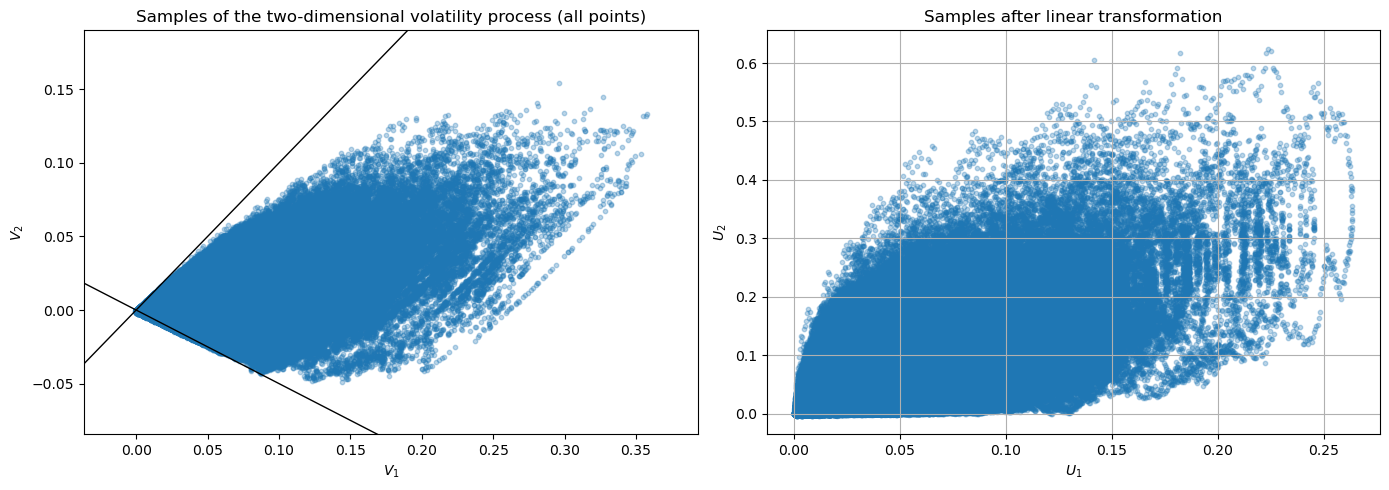

In [22]:
num_simulations = 30

# === Simulation ===
trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, num_simulations)

all_points = trajectories.reshape(-1, 2)
transformed = all_points @ Q.T

# === Tracé des nuages de points ===
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
margin = 0.1 * max(x_max - x_min, y_max - y_min)
x_plot_min = x_min - margin
x_plot_max = x_max + margin
y_plot_min = y_min - margin
y_plot_max = y_max + margin

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(all_points[:, 0], all_points[:, 1], s=10, alpha=0.3)

x_vals = np.linspace(x_plot_min, x_plot_max, 300)
axes[0].plot(x_vals, x_vals, 'k-', linewidth=1)  # y1 = y2
slope = -(w[0] / w[1])
y_vals = slope * x_vals
axes[0].plot(x_vals, y_vals, 'k-', linewidth=1)  # w^T y = 0

axes[0].set_xlim(x_plot_min, x_plot_max)
axes[0].set_ylim(y_plot_min, y_plot_max)
axes[0].set_xlabel(r"$V_1$")
axes[0].set_ylabel(r"$V_2$")
axes[0].set_title("Samples of the two-dimensional volatility process (all points)")

axes[1].scatter(transformed[:, 0], transformed[:, 1], s=10, alpha=0.3)
axes[1].set_xlabel(r"$U_1$")
axes[1].set_ylabel(r"$U_2$")
axes[1].set_title("Samples after linear transformation")
axes[1].grid(True)

plt.tight_layout()
plt.show()
